In [ ]:
import pyopenms as oms

input_file = "converted/Adult_Kidney_Gel_Velos_9_f09.mzML"
exp = oms.MSExperiment()
oms.MzMLFile().load(input_file, exp)
print(f"Successfully loaded {len(exp.getSpectra())} spectra from {input_file}")
import pyopenms as oms

# Initialize the MSExperiment object
exp = oms.MSExperiment()

# Load your mzML file
input_file = "converted/Adult_Kidney_Gel_Velos_9_f09.mzML"
oms.MzMLFile().load(input_file, exp)

# Initialize the SimpleSearchEngineAlgorithm
search_engine = oms.SimpleSearchEngineAlgorithm()

# Prepare lists to store the results
protein_ids = []
peptide_ids = []

# Perform the search
search_engine.search(input_file, "human.fasta", protein_ids, peptide_ids)

# Optionally, save the results to an IdXML file
output_idxml = "identifications.idXML"
oms.IdXMLFile().store(output_idxml, protein_ids, peptide_ids)

print(f"Search completed. Results saved to {output_idxml}")
protein_ids = []
peptide_ids = []
oms.IdXMLFile().load(output_idxml, protein_ids, peptide_ids)
peptide_sequences = set()
for peptide_id in peptide_ids:
    for hit in peptide_id.getHits():
        peptide_sequences.add(hit.getSequence().toString())
fixed_mod_names = [b"Carbamidomethyl (C)"]
variable_mod_names = [b"Oxidation (M)", b"Phospho (S)", b"Phospho (T)", b"Phospho (Y)"]

fixed_modifications = oms.ModifiedPeptideGenerator.getModifications(fixed_mod_names)
variable_modifications = oms.ModifiedPeptideGenerator.getModifications(variable_mod_names)


fixed_modifications = oms.ModifiedPeptideGenerator.getModifications(fixed_mod_names)
variable_modifications = oms.ModifiedPeptideGenerator.getModifications(variable_mod_names)
max_variable_mods = 1
keep_unmodified = False

for seq_str in peptide_sequences:
    sequence = oms.AASequence.fromString(seq_str)
    
    # Apply fixed mods
    oms.ModifiedPeptideGenerator.applyFixedModifications(fixed_modifications, sequence)

    # Generate variable modifications
    peptides_with_variable_modifications = []
    oms.ModifiedPeptideGenerator.applyVariableModifications(variable_modifications, sequence, max_variable_mods,
                                                            peptides_with_variable_modifications, keep_unmodified)

    print(f"\nBase sequence: {seq_str}")
    print(f"Fixed mods applied: {sequence.toString()}, Mass: {sequence.getMonoWeight()}")

    for p in peptides_with_variable_modifications:
        print(f"Variable mod variant: {p.toString()}, Mass: {p.getMonoWeight()}")
import pyopenms as oms


# Prepare data loading (save memory by only
# loading MS1 spectra into memory)
options = oms.PeakFileOptions()
options.setMSLevels([1])
fh = oms.MzMLFile()
fh.setOptions(options)

# Load data
input_map = oms.MSExperiment()
fh.load(input_file, input_map)
input_map.updateRanges()

ff = oms.FeatureFinderAlgorithmPicked()

# Run the feature finder
out_features = oms.FeatureMap()  ## our result
seeds = oms.FeatureMap()     ## optional: you can provide seeds where FF should take place -- not used here
params = ff.getParameters(); ## we do not modify params for now
ff.run(input_map, out_features, params, seeds)

out_features.setUniqueIds()
fh = oms.FeatureXMLFile()
fh.store("output.featureXML", out_features)
print("Found", out_features.size(), "features")
f0 = out_features[0]
for f in out_features:
    print(f.getRT(), f.getMZ())


import pyopenms as oms

feature_map = oms.FeatureMap()
oms.FeatureXMLFile().load("output.featureXML", feature_map)
peptide_ids = []
protein_ids = []
oms.IdXMLFile().load("output.idXML", protein_ids, peptide_ids)
id_mapper = oms.IDMapper()
params = id_mapper.getParameters()
params.setValue("rt_tolerance", 5.0)  # RT tolerance in seconds
params.setValue("mz_tolerance", 10.0)  # m/z tolerance in ppm
id_mapper.setParameters(params)
# annotate() can optionally use the underlying raw MS data (spectra) to annotate unidentified MS/MS scans to features in the FeatureMap
# We don't need this here, so we provide an empty default.
spectra = oms.MSExperiment()
id_mapper.annotate(feature_map, peptide_ids, protein_ids, True, True, spectra)
oms.FeatureXMLFile().store("data_annotated.featureXML", feature_map)


import csv
import pyopenms as oms

# Load your feature map and IDs
feature_map = oms.FeatureMap()
oms.FeatureXMLFile().load("data_annotated.featureXML", feature_map)

protein_ids = []
peptide_ids = []
oms.IdXMLFile().load("output.idXML", protein_ids, peptide_ids)

# Build a dictionary of all peptides from your peptide_ids with modifications
peptides_with_mods = set()
for pep_id in peptide_ids:
    for hit in pep_id.getHits():
        peptides_with_mods.add(hit.getSequence().toString())

# Open a CSV file for writing
with open("ptm_quantification.csv", mode="w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header
    csv_writer.writerow(["Peptide", "Intensity", "RT", "m/z"])
    
    # Loop through features to get intensity for peptides of interest and write rows
    for feature in feature_map:
        peptide_ids = feature.getPeptideIdentifications()
        if not peptide_ids:
            continue
        for pep_id in peptide_ids:
            for hit in pep_id.getHits():
                pep_seq = hit.getSequence().toString()
                if pep_seq in peptides_with_mods:
                    intensity = feature.getIntensity()
                    rt = feature.getRT()
                    mz = feature.getMZ()
                    csv_writer.writerow([pep_seq, intensity, rt, mz])

print("Export complete: ptm_quantification.csv")
import pyopenms as oms

# Load the identification results
protein_ids = []
peptide_ids = []
oms.IdXMLFile().load("output.idXML", protein_ids, peptide_ids)

# Open a file for writing the peptide FASTA sequences
with open("peptides.fasta", "w") as fasta_file:
    for pep_id in peptide_ids:
        for hit in pep_id.getHits():
            # Get the peptide sequence and its modifications
            sequence = hit.getSequence()
            
            # Create a unique header for the FASTA entry
            header = f">Peptide_{sequence.toString().replace(')', '').replace('(', '')}"
            
            # Write the header and the sequence
            fasta_file.write(header + "\n")
            fasta_file.write(sequence.toUnmodifiedString() + "\n")

print("Peptide sequences saved to peptides.fasta")
import pyopenms as oms

# Load the protein identifications
protein_ids = []
peptide_ids = []
oms.IdXMLFile().load("output.idXML", protein_ids, peptide_ids)

# Load the original FASTA database
fasta_file = "human.fasta" 
protein_sequences = [] 
oms.FASTAFile().load(fasta_file, protein_sequences)

# Open a file for writing the protein FASTA sequences
with open("proteins.fasta", "w") as fasta_file:
    # Use a set to avoid writing duplicate proteins
    identified_proteins = set()
    
    # Create a mapping from identifier to FASTAEntry for fast lookup
    fasta_map = {p.identifier: p for p in protein_sequences}

    for prot_id in protein_ids:
        for hit in prot_id.getHits():
            accession = hit.getAccession()
            if accession not in identified_proteins and accession in fasta_map:
                # Get the protein sequence from the loaded map
                sequence_obj = fasta_map[accession]
                
                # Create the FASTA header
                header = f">{sequence_obj.identifier}"
                
                # Write the header and sequence
                fasta_file.write(header + "\n")
                fasta_file.write(sequence_obj.sequence + "\n")
                identified_proteins.add(accession)

print("Protein sequences saved to proteins.fasta")
protein_ids = []
peptide_ids = []
oms.SimpleSearchEngineAlgorithm().search(
    input_file, "human.fasta", protein_ids, peptide_ids
)


for peptide_id in peptide_ids:
    # Peptide identification values
    print(35 * "=")
    print("Peptide ID m/z:", peptide_id.getMZ())
    print("Peptide ID rt:", peptide_id.getRT())
    print("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print("Peptide scan name:", peptide_id.getMetaValue("scan_index"))
    print("Peptide ID score type:", peptide_id.getScoreType())
    # PeptideHits
    for hit in peptide_id.getHits():
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit charge:", hit.getCharge())
        print(" - Peptide hit sequence:", hit.getSequence())
        mz = (
            hit.getSequence().getMonoWeight(
                oms.Residue.ResidueType.Full, hit.getCharge()
            )
            / hit.getCharge()
        )
        print(" - Peptide hit monoisotopic m/z:", mz)
        print(
            " - Peptide ppm error:", abs(mz - peptide_id.getMZ()) / mz * 10**6
        )
        print(" - Peptide hit score:", hit.getScore())

tsg = oms.TheoreticalSpectrumGenerator()
thspec = oms.MSSpectrum()
p = oms.Param()
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = oms.AASequence.fromString("EDSVKPGAHLTVK")
tsg.getSpectrum(thspec, peptide, 1, 1)
# Iterate over annotated ions and their masses
for ion, peak in zip(thspec.getStringDataArrays()[0], thspec):
    print(ion, peak.getMZ())

e = oms.MSExperiment()
oms.MzMLFile().load(input_file, e)
print("Spectrum native id", e[2].getNativeID())
mz, i = e[2].get_peaks()
peaks = [(mz, i) for mz, i in zip(mz, i) if i > 1500 and mz > 300]
for peak in peaks:
    print(peak[0], "mz", peak[1], "int")    
    
        
    
from urllib.request import urlretrieve

searchfile = input_file
searchdb = "human.fasta"

# generate a protein database with additional decoy sequenes
targets = list()
decoys = list()
oms.FASTAFile().load(
    searchdb, targets
)  # read FASTA file into a list of FASTAEntrys
decoy_generator = oms.DecoyGenerator()
for entry in targets:
    rev_entry = oms.FASTAEntry(entry)  # copy entry
    rev_entry.identifier = "DECOY_" + rev_entry.identifier  # mark as decoy
    aas = oms.AASequence().fromString(
        rev_entry.sequence
    )  # convert string into amino acid sequence
    rev_entry.sequence = decoy_generator.reverseProtein(
        aas
    ).toString()  # reverse
    decoys.append(rev_entry)

target_decoy_database = "search_td.fasta"
oms.FASTAFile().store(
    target_decoy_database, targets + decoys
)  # store the database with appended decoy sequences

# Run SimpleSearchAlgorithm, store protein and peptide ids
protein_ids = []
peptide_ids = []

# set some custom search parameters
simplesearch = oms.SimpleSearchEngineAlgorithm()
params = simplesearch.getDefaults()
score_annot = [b"fragment_mz_error_median_ppm", b"precursor_mz_error_ppm"]
params.setValue(b"annotate:PSM", score_annot)
params.setValue(b"peptide:max_size", 30)
simplesearch.setParameters(params)

simplesearch.search(searchfile, target_decoy_database, protein_ids, peptide_ids)

# Annotate q-value
oms.FalseDiscoveryRate().apply(peptide_ids)

# Filter by 1% PSM FDR (q-value < 0.01)
idfilter = oms.IDFilter()
idfilter.filterHitsByScore(peptide_ids, 0.01)
idfilter.removeDecoyHits(peptide_ids)

# store PSM-FDR filtered
oms.IdXMLFile().store(
    "searchfile_results_1perc_FDR.idXML", protein_ids, peptide_ids
)
import pyopenms as poms


# open example input feature map
feature_map = poms.FeatureMap()
poms.FeatureXMLFile().load("output.featureXML", feature_map)

# initialize MetaboliteFeatureDeconvolution
mfd = poms.MetaboliteFeatureDeconvolution()

# get default parameters
params = mfd.getDefaults()
# update/explain most important parameters

# adducts to expect: elements, charge and probability separated by colon
# the total probability of all charged adducts needs to be 1
# e.g. positive mode:
# proton dduct "H:+:0.6", sodium adduct "Na:+:0.4" and neutral water loss "H-2O-1:0:0.2"
# e.g. negative mode:
# with neutral formic acid adduct: "H-1:-:1", "CH2O2:0:0.5"
# multiples don't need to be specified separately:
# e.g. [M+H2]2+ and double water loss will be detected as well!
# optionally, retention time shifts caused by adducts can be added
# e.g. a formic acid adduct causes 3 seconds earlier elution "CH2O2:0:0.5:-3"
params.setValue("potential_adducts", ["H:+:0.6", "Na:+:0.4", "H-2O-1:0:0.2"])

# expected charge range
# e.g. for positive mode metabolomics:
# minimum of 1, maximum of 3, maximum charge span for a single feature 3
# for negative mode:
# charge_min = -3, charge_max = -1
params.setValue("charge_min", 1, "Minimal possible charge")
params.setValue("charge_max", 3, "Maximal possible charge")
params.setValue("charge_span_max", 3)

# maximum RT difference between any two features for grouping
# maximum RT difference between between two co-features, after adduct shifts have been accounted for
# (if you do not have any adduct shifts, this value should be equal to "retention_max_diff")
params.setValue("retention_max_diff", 3.0)
params.setValue("retention_max_diff_local", 3.0)

# set updated paramters object
mfd.setParameters(params)

# result feature map: will store features with adduct information
feature_map_MFD = poms.FeatureMap()
# result consensus map: will store grouped features belonging to a charge group
groups = poms.ConsensusMap()
# result consensus map: will store paired features connected by an edge
edges = poms.ConsensusMap()

# compute adducts
mfd.compute(feature_map, feature_map_MFD, groups, edges)

# export feature map as pandas DataFrame and append adduct information
df = feature_map_MFD.get_df(export_peptide_identifications=False)
df["adduct"] = [f.getMetaValue("dc_charge_adducts") for f in feature_map_MFD]

# display data
print(df.head())

from pyopenms import *

proteins = []
peptides = []

idf = IdXMLFile()
idf.load("output_pep.idXML", proteins, peptides)

# Run IDPosteriorErrorProbability algorithm to compute PEPs

# Now run BayesianProteinInferenceAlgorithm
bpia = BayesianProteinInferenceAlgorithm()
params = bpia.getParameters()
params.setValue("update_PSM_probabilities", "false")
bpia.setParameters(params)

bpia.inferPosteriorProbabilities(proteins, peptides, False)

print(len(peptides))
print(peptides[0].getHits()[0].getScore())
print(proteins[0].getHits()[0].getScore())
print(proteins[0].getHits()[1].getScore())



Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


Successfully loaded 8926 spectra from converted/Adult_Kidney_Gel_Velos_9_f09.mzML
Proteins: 20420
Peptides: 1369684
Processed peptides: 1369684
Search completed. Results saved to identifications.idXML
Peptide identification engine: SIMPLESEARCHENGINE
Enzyme: Trypsin
Building trie ... done (0s)
Compressing trie to BFS format ...
 done (0s)
Mapping 5955 peptides to 20420 proteins.
Searching with up to 3 ambiguous amino acid(s) and 0 mismatch(es)!
Merge took: 0.00 s (wall), 0.00 s (CPU), 0.00 s (system), 0.00 s (user)
Memory usage (Aho-Corasick): 7 MB (working set delta), 7 MB (peak working set delta)


Aho-Corasick done:
  found 7291 hits for 5955 of 5955 peptides.
Peptide hits passing enzyme filter: 7291
     ... rejected by enzyme filter: 98
-----------------------------------
Peptide statistics

  unmatched                : 0 (0 %)
  target/decoy:
    match to target DB only: 5955 (100 %)
    match to decoy DB only : 0 (0 %)
    match to both          : 0 (0 %)

  mapping to proteins:

In [ ]:
import pyopenms
print(pyopenms.__version__)
print(dir(pyopenms))  # See what classes are available
getMSLevels = exp.getMSLevels()
print("MS Levels:", getMSLevels)
spec = exp[1]
mz, intensity = spec.get_peaks()
print(sum(intensity))
for peak in spec:
    print(peak.getIntensity())
# Calculates total ion current of an LC-MS/MS experiment
def calcTIC(exp, mslevel):
    tic = 0
    # Iterate through all spectra of the experiment
    for spec in exp:
        # Only calculate TIC for matching (MS1) spectra
        if spec.getMSLevel() == mslevel:
            mz, i = spec.get_peaks()
            tic += sum(i)
    return tic
print(calcTIC(exp, 1))
print(sum([sum(s.get_peaks()[1]) for s in exp if s.getMSLevel() == 1]))
print(calcTIC(exp, 1))


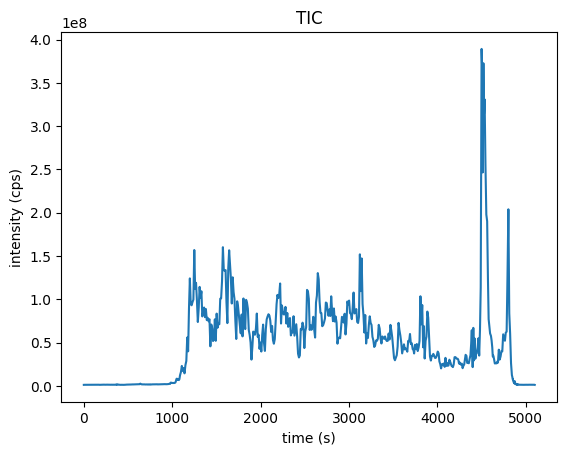

In [7]:
import matplotlib.pyplot as plt
# 1) get TIC data using the calculateTIC() method

tic = exp.calculateTIC()
retention_times, intensities = tic.get_peaks()

# 2) get TIC data using list comprehensions
retention_times = [spec.getRT() for spec in exp]
intensities = [
    sum(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1
]

# 3) get TIC data looping over spectra in MSExperiment()
retention_times = []
intensities = []
for spec in exp:
    if spec.getMSLevel() == 1:
        retention_times.append(spec.getRT())
        intensities.append(sum(spec.get_peaks()[1]))

# plot retention times and intensities and add labels
plt.plot(retention_times, intensities)

plt.title("TIC")
plt.xlabel("time (s)")
plt.ylabel("intensity (cps)")

plt.show()

In [8]:
# Peak picking using PeakPickerHiRes if no peak picking was done before
import pyopenms as oms

# Initialize MSExperiment objects correctly
exp = oms.MSExperiment()
picked = oms.MSExperiment()

# Load data
oms.MzMLFile().load(input_file, exp)

# Initialize PeakPickerHiRes and process each spectrum
peakpicker = oms.PeakPickerHiRes()
for spectrum in exp:
    picked_spectrum = oms.MSSpectrum()
    peakpicker.pick(spectrum, picked_spectrum)
    picked.addSpectrum(picked_spectrum)

print(f"Original spectra: {len(exp.getSpectra())}")
print(f"Picked spectra: {len(picked.getSpectra())}")

Original spectra: 8926
Picked spectra: 8926


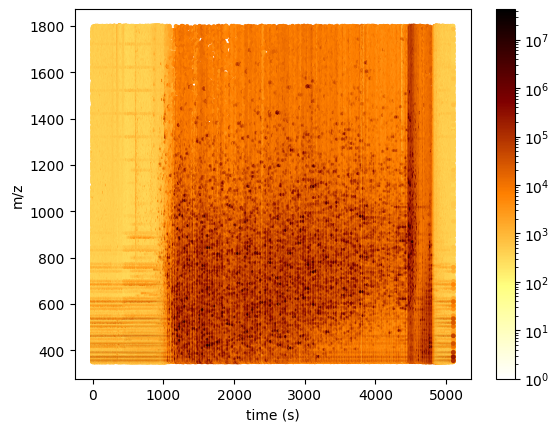

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


def plot_spectra_2D(exp, ms_level=1, marker_size=5):
    exp.updateRanges()
    for spec in exp:
        if spec.getMSLevel() == ms_level:
            mz, intensity = spec.get_peaks()
            p = intensity.argsort()  # sort by intensity to plot highest on top
            rt = np.full([mz.shape[0]], spec.getRT(), float)
            plt.scatter(
                rt,
                mz[p],
                c=intensity[p],
                cmap="afmhot_r",
                s=marker_size,
                norm=colors.LogNorm(
                    exp.getMinIntensity() + 1, exp.getMaxIntensity()
                ),
            )
    plt.clim(exp.getMinIntensity() + 1, exp.getMaxIntensity())
    plt.xlabel("time (s)")
    plt.ylabel("m/z")
    plt.colorbar()
    plt.show()  # slow for larger data sets



exp = oms.MSExperiment()
oms.MzMLFile().load(input_file, exp)

plot_spectra_2D(exp)